In [1]:
import dask
import icechunk
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from tqdm import tqdm

from ocr.config import ChunkingConfig

In [2]:
c = ChunkingConfig()
c

<POLYGON ((-64.054 22.428, -64.054 52.482, -128.387 52.482, -128.387 22.428,...>

In [3]:
version = 'v0.9.0'
storage = icechunk.s3_storage(
    bucket='carbonplan-ocr', prefix=f'output/fire-risk/tensor/production/{version}/ocr.icechunk'
)
repo = icechunk.Repository.open(storage)
session = repo.readonly_session('main')

ds = xr.open_dataset(session.store, chunks={}, engine='zarr')[['wind_risk_2011', 'wind_risk_2047']]
ds

<xarray.Dataset> Size: 163GB
Dimensions:         (latitude: 97579, longitude: 208881)
Coordinates:
  * latitude        (latitude) float64 781kB 22.43 22.43 22.43 ... 52.48 52.48
  * longitude       (longitude) float64 2MB -128.4 -128.4 ... -64.05 -64.05
Data variables:
    wind_risk_2011  (latitude, longitude) float32 82GB dask.array<chunksize=(6000, 4500), meta=np.ndarray>
    wind_risk_2047  (latitude, longitude) float32 82GB dask.array<chunksize=(6000, 4500), meta=np.ndarray>

In [4]:
results = []
for region_id in tqdm(c.valid_region_ids):
    lat_slice, lon_slice = c.region_id_to_latlon_slices(region_id)
    nan_count = (
        ds.sel(latitude=lat_slice, longitude=lon_slice)
        .isnull()
        .sum()
        .expand_dims({'region_id': [region_id]})
    )
    results.append(nan_count)

100%|██████████| 405/405 [00:01<00:00, 249.21it/s]


In [5]:
%%time
dsets = dask.compute(*results)
dset = xr.concat(dsets, dim='region_id')
dset

CPU times: user 2min 15s, sys: 1min 30s, total: 3min 46s
Wall time: 51.4 s


<xarray.Dataset> Size: 10kB
Dimensions:         (region_id: 405)
Coordinates:
  * region_id       (region_id) object 3kB 'y1_x21' 'y1_x22' ... 'y14_x28'
Data variables:
    wind_risk_2011  (region_id) int64 3kB 26780207 25704414 ... 26999817
    wind_risk_2047  (region_id) int64 3kB 26780207 25704414 ... 26999817

In [6]:
# Calculate total cells per region and NaN ratios
total_cells_per_region = []
for region_id in c.valid_region_ids:
    lat_slice, lon_slice = c.region_id_to_latlon_slices(region_id)
    region_data = ds.sel(latitude=lat_slice, longitude=lon_slice)
    total = region_data['wind_risk_2011'].size
    total_cells_per_region.append(total)

# Add total cells and ratios to dataset
dset = dset.assign({'total_cells': ('region_id', total_cells_per_region)})
dset['nan_ratio_2011'] = (dset['wind_risk_2011'] / dset['total_cells']).astype('float32')
dset['nan_ratio_2047'] = (dset['wind_risk_2047'] / dset['total_cells']).astype('float32')
dset

<xarray.Dataset> Size: 16kB
Dimensions:         (region_id: 405)
Coordinates:
  * region_id       (region_id) object 3kB 'y1_x21' 'y1_x22' ... 'y14_x28'
Data variables:
    wind_risk_2011  (region_id) int64 3kB 26780207 25704414 ... 26999817
    wind_risk_2047  (region_id) int64 3kB 26780207 25704414 ... 26999817
    total_cells     (region_id) int64 3kB 27000000 27000000 ... 27000000
    nan_ratio_2011  (region_id) float32 2kB 0.9919 0.952 0.9997 ... 0.9949 1.0
    nan_ratio_2047  (region_id) float32 2kB 0.9919 0.952 0.9997 ... 0.9949 1.0

In [7]:
# %%time
# dset.to_zarr(
#     f's3://carbonplan-ocr/evaluation/conus-wide-nan-count-per-region-{version}.zarr',
#     consolidated=True,
#     zarr_format=2,
# )

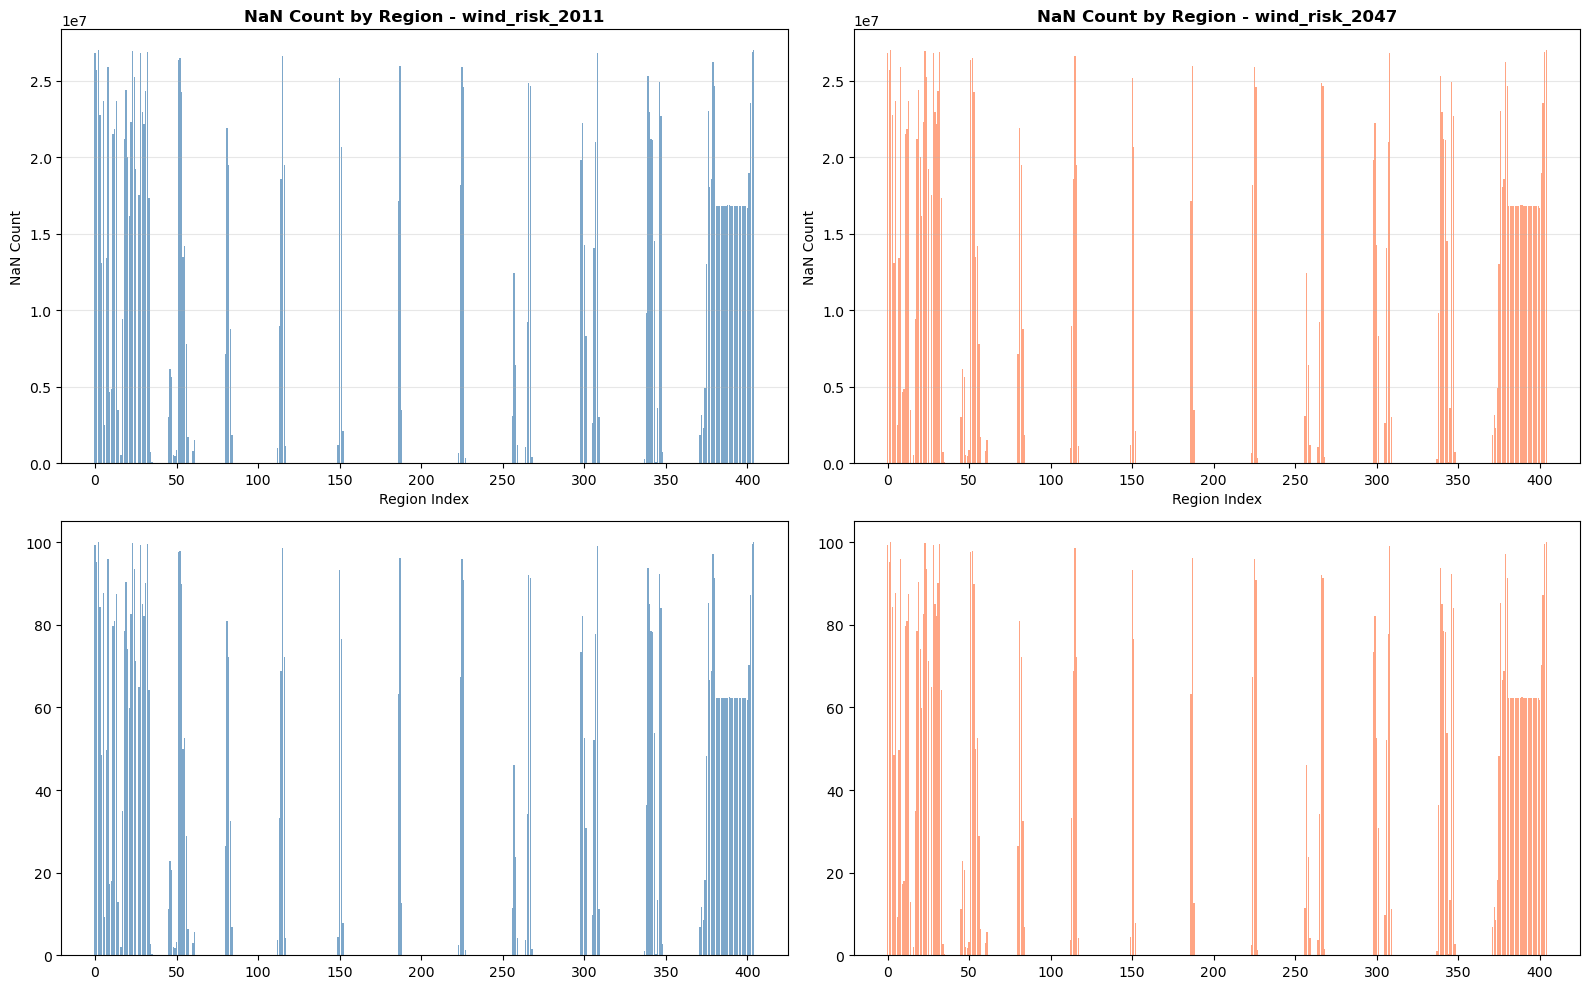


Top 20 regions with highest NaN ratios:

wind_risk_2011:
  y14_x28: 100.00% (26,999,817 NaNs)
  y1_x32: 99.97% (26,990,942 NaNs)
  y3_x30: 99.83% (26,953,848 NaNs)
  y4_x15: 99.56% (26,882,486 NaNs)
  y14_x26: 99.49% (26,861,673 NaNs)
  y4_x11: 99.20% (26,784,187 NaNs)
  y1_x21: 99.19% (26,780,207 NaNs)
  y11_x44: 99.17% (26,774,766 NaNs)
  y6_x38: 98.52% (26,601,347 NaNs)
  y5_x6: 97.96% (26,448,808 NaNs)
  y4_x34: 97.63% (26,359,102 NaNs)
  y14_x2: 97.21% (26,247,583 NaNs)
  y9_x2: 96.04% (25,930,360 NaNs)
  y2_x32: 95.97% (25,912,416 NaNs)
  y9_x40: 95.89% (25,889,953 NaNs)
  y1_x22: 95.20% (25,704,414 NaNs)
  y12_x33: 93.78% (25,321,635 NaNs)
  y3_x31: 93.41% (25,221,338 NaNs)
  y7_x38: 93.31% (25,193,506 NaNs)
  y12_x44: 92.19% (24,892,465 NaNs)

wind_risk_2047:
  y14_x28: 100.00% (26,999,817 NaNs)
  y1_x32: 99.97% (26,990,942 NaNs)
  y3_x30: 99.83% (26,953,848 NaNs)
  y4_x15: 99.56% (26,882,486 NaNs)
  y14_x26: 99.49% (26,861,673 NaNs)
  y4_x11: 99.20% (26,784,187 NaNs)
  y1_x21

In [8]:
region_ids = dset['region_id'].values
x_pos = range(len(region_ids))

# Find top regions with highest NaN ratios
top_n = 20
top_2011_idx = np.argsort(dset['nan_ratio_2011'].values)[-top_n:]
top_2047_idx = np.argsort(dset['nan_ratio_2047'].values)[-top_n:]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Bar plot - NaN counts for 2011
axes[0, 0].bar(x_pos, dset['wind_risk_2011'].values, alpha=0.7, color='steelblue')
axes[0, 0].set_title('NaN Count by Region - wind_risk_2011', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Region Index')
axes[0, 0].set_ylabel('NaN Count')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Bar plot - NaN counts for 2047
axes[0, 1].bar(x_pos, dset['wind_risk_2047'].values, alpha=0.7, color='coral')
axes[0, 1].set_title('NaN Count by Region - wind_risk_2047', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Region Index')
axes[0, 1].set_ylabel('NaN Count')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Bar plot - NaN ratios for 2011 with labels
bars_2011 = axes[1, 0].bar(x_pos, dset['nan_ratio_2011'].values * 100, alpha=0.7, color='steelblue')

# Bar plot - NaN ratios for 2047 with labels
bars_2047 = axes[1, 1].bar(x_pos, dset['nan_ratio_2047'].values * 100, alpha=0.7, color='coral')

plt.tight_layout()
plt.show()

# Print summary of regions with highest NaN ratios
print(f'\nTop {top_n} regions with highest NaN ratios:')
print('\nwind_risk_2011:')
for idx in top_2011_idx[::-1]:
    print(
        f'  {region_ids[idx]}: {dset["nan_ratio_2011"].values[idx] * 100:.2f}% ({dset["wind_risk_2011"].values[idx]:,} NaNs)'
    )

print('\nwind_risk_2047:')
for idx in top_2047_idx[::-1]:
    print(
        f'  {region_ids[idx]}: {dset["nan_ratio_2047"].values[idx] * 100:.2f}% ({dset["wind_risk_2047"].values[idx]:,} NaNs)'
    )

/opt/coiled/env/lib/python3.13/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/coiled/env/lib/python3.13/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/coiled/env/lib/python3.13/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


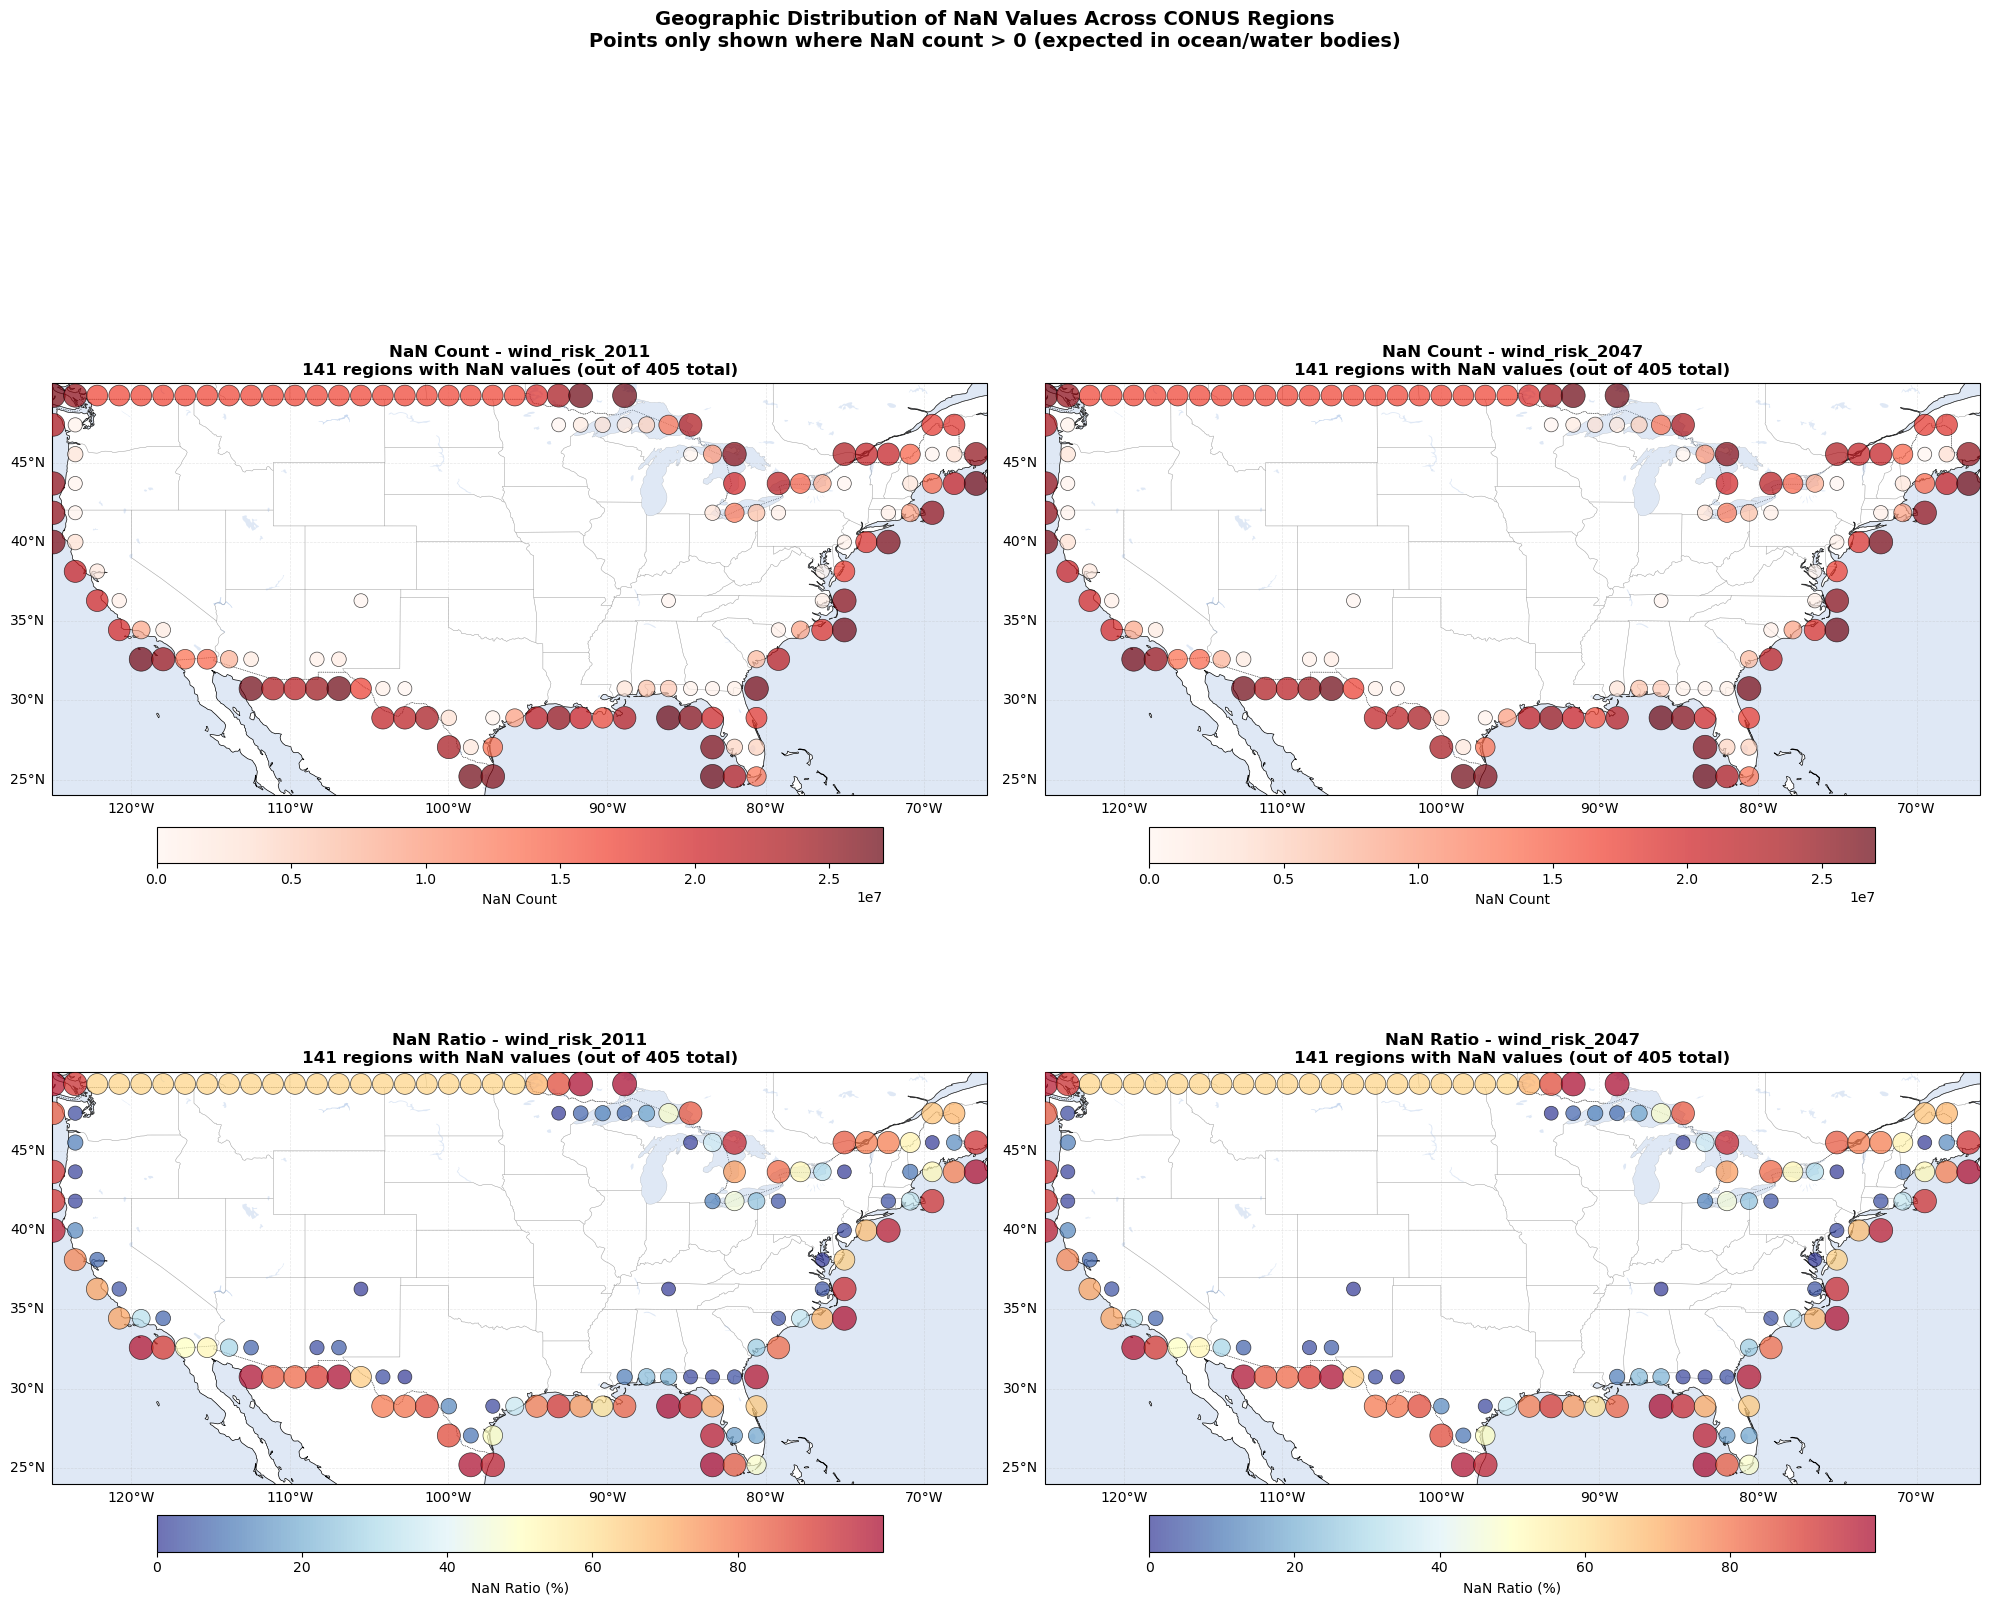


NaN Distribution Statistics:
Total regions: 405

wind_risk_2011:
  Regions with NaNs: 141
  Max NaN count: 26,999,817
  Total NaN pixels: 1,989,184,048

wind_risk_2047:
  Regions with NaNs: 141
  Max NaN count: 26,999,817
  Total NaN pixels: 1,989,184,048


In [9]:
# Get centroid coordinates for each region
import cartopy.crs as ccrs
import cartopy.feature as cfeature

centroids = []
for region_id in dset['region_id'].values:
    lat_slice, lon_slice = c.region_id_to_latlon_slices(region_id)
    # Calculate centroid
    lat_center = (lat_slice.start + lat_slice.stop) / 2
    lon_center = (lon_slice.start + lon_slice.stop) / 2
    centroids.append((lon_center, lat_center))

lons, lats = zip(*centroids)
lons = np.array(lons)
lats = np.array(lats)

# Create geographic scatter plots
fig, axes = plt.subplots(2, 2, figsize=(20, 16), subplot_kw={'projection': ccrs.PlateCarree()})

# Flatten axes for easier iteration
axes_flat = axes.flatten()

# Variables and titles
variables = ['wind_risk_2011', 'wind_risk_2047', 'nan_ratio_2011', 'nan_ratio_2047']
titles = [
    'NaN Count - wind_risk_2011',
    'NaN Count - wind_risk_2047',
    'NaN Ratio - wind_risk_2011',
    'NaN Ratio - wind_risk_2047',
]
cmaps = ['Reds', 'Reds', 'RdYlBu_r', 'RdYlBu_r']

for idx, (var, title, cmap_name) in enumerate(zip(variables, titles, cmaps)):
    ax = axes_flat[idx]

    # Add geographic features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')
    ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='gray', alpha=0.5)
    ax.add_feature(cfeature.OCEAN, alpha=0.3)
    ax.add_feature(cfeature.LAKES, alpha=0.3)

    # Get values
    if 'ratio' in var:
        values = dset[var].values * 100  # Convert to percentage
        vmin, vmax = 0, max(values) if max(values) > 0 else 1
        label = 'NaN Ratio (%)'
    else:
        values = dset[var].values
        vmin, vmax = 0, max(values) if max(values) > 0 else 1
        label = 'NaN Count'

    # Create scatter plot with size based on value
    # Only show points with NaN count > 0
    mask = values > 0
    scatter = ax.scatter(
        lons[mask],
        lats[mask],
        c=values[mask],
        s=100 + values[mask] / max(values) * 200
        if max(values) > 0
        else 100,  # Size varies with value
        cmap=cmap_name,
        alpha=0.7,
        edgecolors='black',
        linewidth=0.5,
        vmin=vmin,
        vmax=vmax,
        transform=ccrs.PlateCarree(),
        zorder=5,
    )

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04, orientation='horizontal')
    cbar.set_label(label, fontsize=10)

    # Set title
    ax.set_title(
        f'{title}\n{mask.sum()} regions with NaN values (out of {len(values)} total)',
        fontsize=12,
        fontweight='bold',
    )

    # Set extent to CONUS
    ax.set_extent([-125, -66, 24, 50], crs=ccrs.PlateCarree())

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

plt.tight_layout()
plt.suptitle(
    'Geographic Distribution of NaN Values Across CONUS Regions\n'
    + 'Points only shown where NaN count > 0 (expected in ocean/water bodies)',
    fontsize=14,
    fontweight='bold',
    y=1.00,
)
plt.subplots_adjust(top=0.96)
plt.show()

# Print statistics
print('\nNaN Distribution Statistics:')
print(f'Total regions: {len(dset.region_id)}')
print('\nwind_risk_2011:')
print(f'  Regions with NaNs: {(dset["wind_risk_2011"] > 0).sum().values}')
print(f'  Max NaN count: {dset["wind_risk_2011"].max().values:,}')
print(f'  Total NaN pixels: {dset["wind_risk_2011"].sum().values:,}')

print('\nwind_risk_2047:')
print(f'  Regions with NaNs: {(dset["wind_risk_2047"] > 0).sum().values}')
print(f'  Max NaN count: {dset["wind_risk_2047"].max().values:,}')
print(f'  Total NaN pixels: {dset["wind_risk_2047"].sum().values:,}')